In [2]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import pytorch_lightning as pl
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid 
from PIL import Image

In [3]:
from pytorch_lightning.callbacks import early_stopping, model_checkpoint, ProgressBar
from pl_bolts.models.self_supervised import Moco_v2, BYOL
from pl_bolts.transforms.dataset_normalizations import imagenet_normalization

In [4]:
# dataset_path="processed_data/"

# dfs= []

# for filepath in glob.glob(dataset_path+"/*/*.json"):
#     with open(filepath, "r") as file:
        
#         data = json.load(file)
#         df = pd.DataFrame(data["result"])
#         slide = os.path.basename(data["slide"]).split(".")[0]
#         df["local_class"] = df["class"] == "tumor"
#         df["global_class"] = slide.split("_")[0] == "tumor"
#         df["path"] = os.path.join(os.path.dirname(filepath), "patches") + "/" + df["class"] + "/" + df["x"].astype(str).str.zfill(6)+"_"+df["y"].astype(str).str.zfill(6)+".png"
#         df = df.drop(columns=["w", "h", "class"])
#         dfs.append(df)

# dataset = pd.concat(dfs)

# dataset_path="processed_data/"
# dataset.set_index(["path"])
# dataset.to_csv(dataset_path+"data.csv")

# dataset["path"].values

In [5]:
class Camelyon16PreprocessedDataset(torch.utils.data.Dataset):
    """
    Dataset of unlabelled patches
    """
    
    def __init__(self, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        patch = self.data.iloc[idx]
        img = Image.open(patch["path"]).convert('RGB')
        img2 = img
        label = patch["local_class"]
        
        if self.transforms is not None:
            img_t = self.transforms[0](img)
            img2_t = self.transforms[1](img)
            
        return (img_t, img2_t), label
    
    

In [11]:
    
moco_trasform = transforms.Compose([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
                                   transforms.GaussianBlur(23, sigma=(0.1, 2.0)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomResizedCrop(224),
                                   transforms.RandomGrayscale(),
                                   transforms.ToTensor(),
                                   imagenet_normalization()])
    
    
class Camelyon16Preprocessed(pl.LightningDataModule):
    """"""
    
    def __init__(self, data_path="processed_data"):
        super().__init__()
        self.data_path = data_path
        
    def train_dataloader(self):
        dataset = Camelyon16PreprocessedDataset(os.path.join(self.data_path, "data.csv"),
                                       transforms=[moco_trasform, moco_trasform])
                                        
        
        dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=64,
                                         shuffle=True,
                                         num_workers=1,
                                         drop_last=True)
        return dataloader

In [12]:
dataloader = Camelyon16Preprocessed().train_dataloader()

In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
denormalize = lambda x: x*std[None, :, None, None] + mean[None, :, None, None]

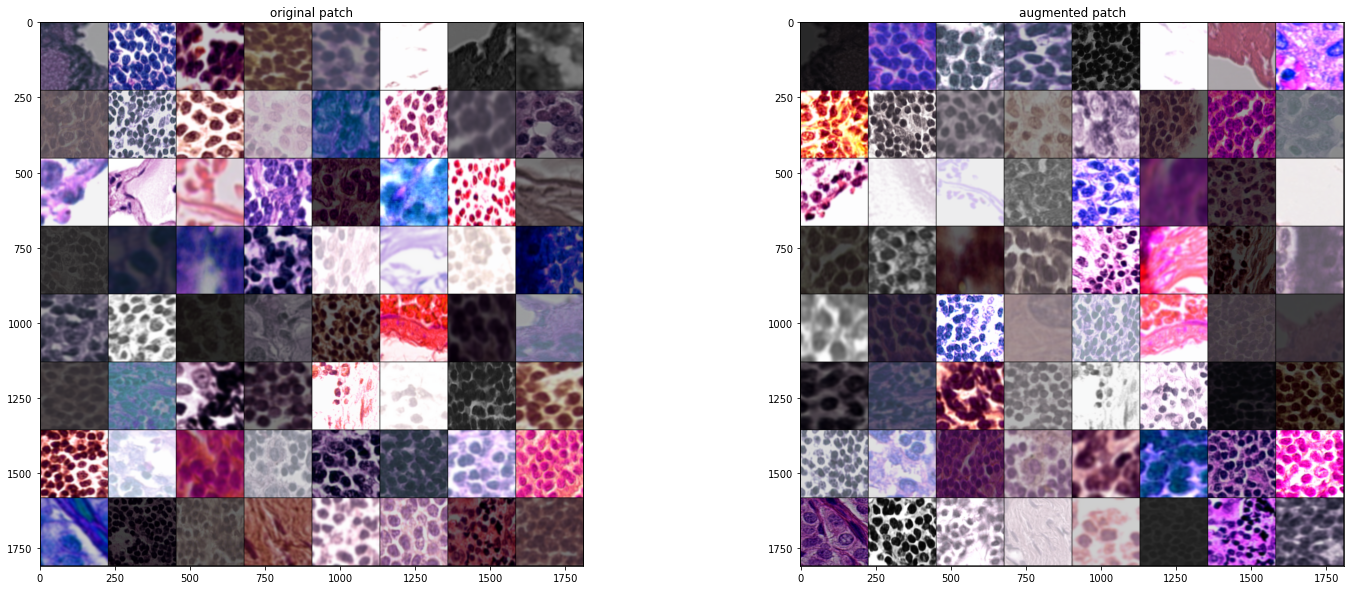

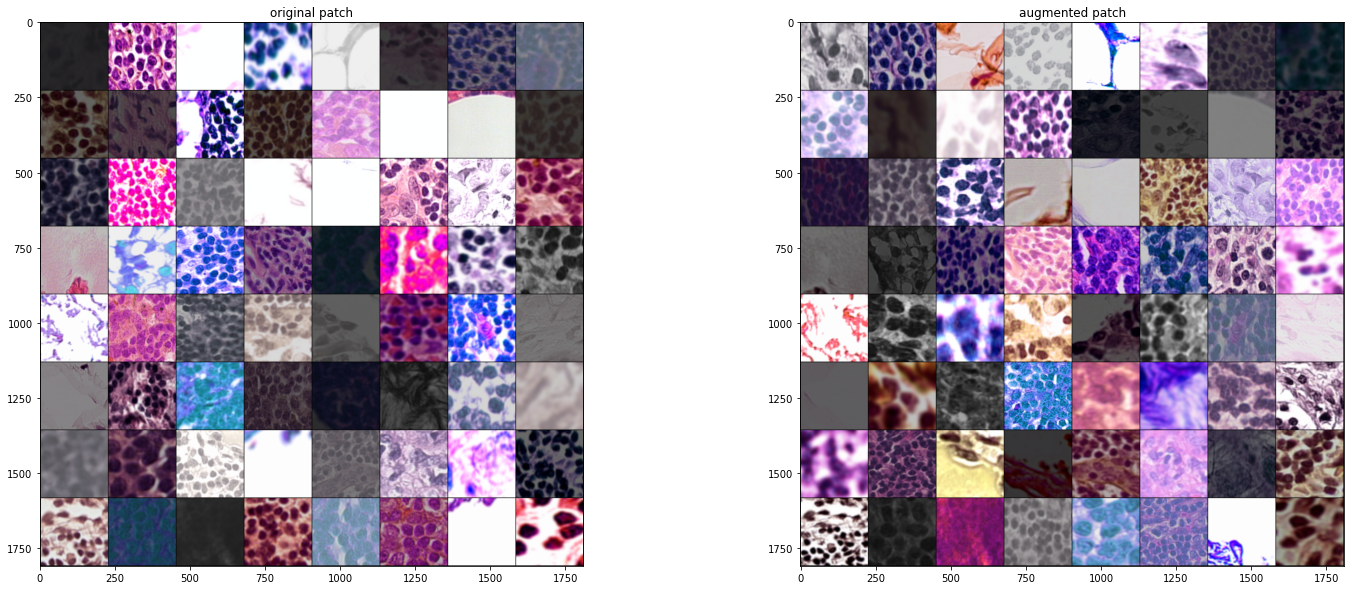

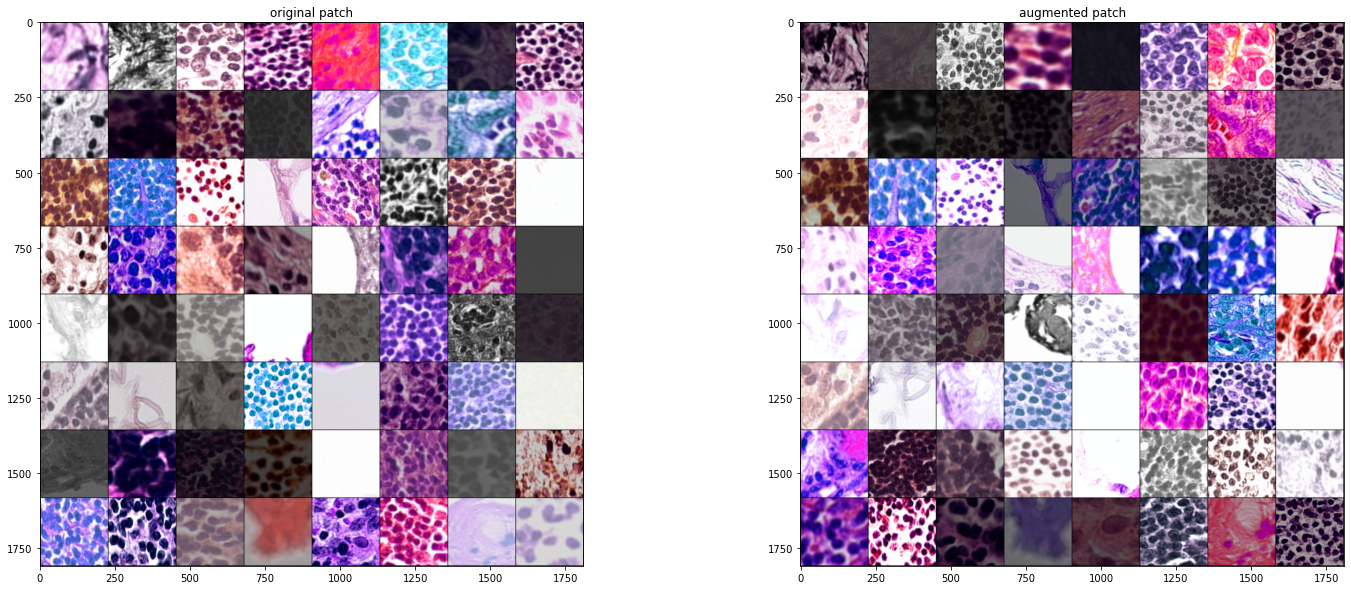

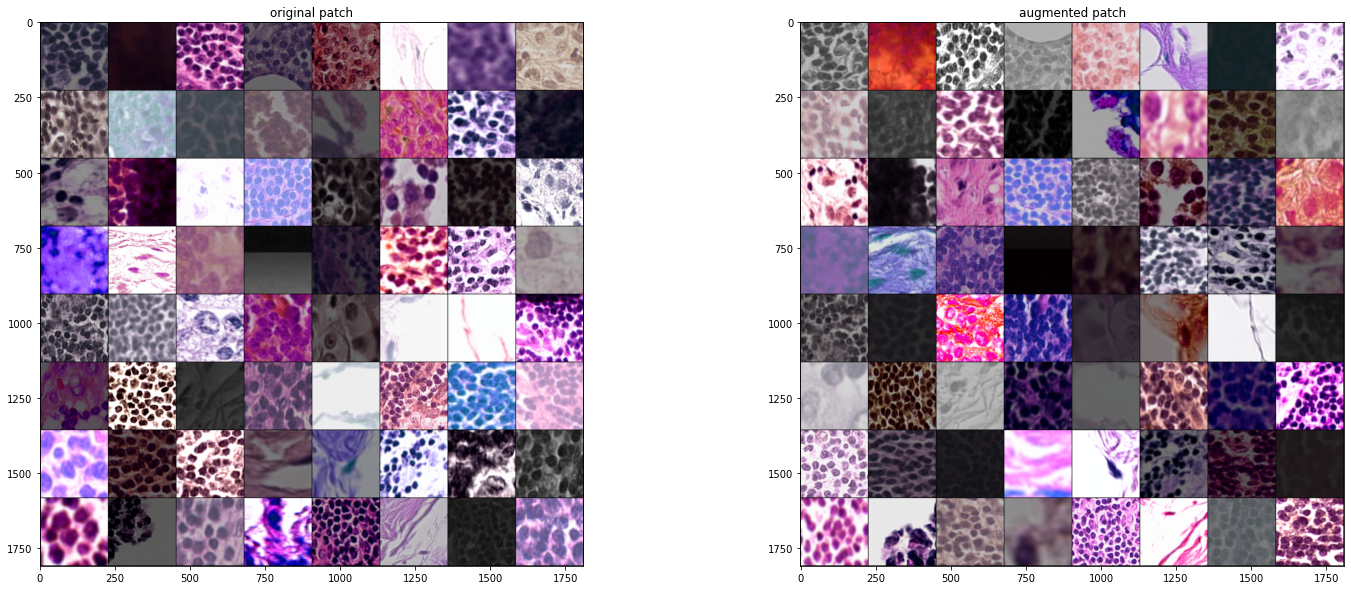

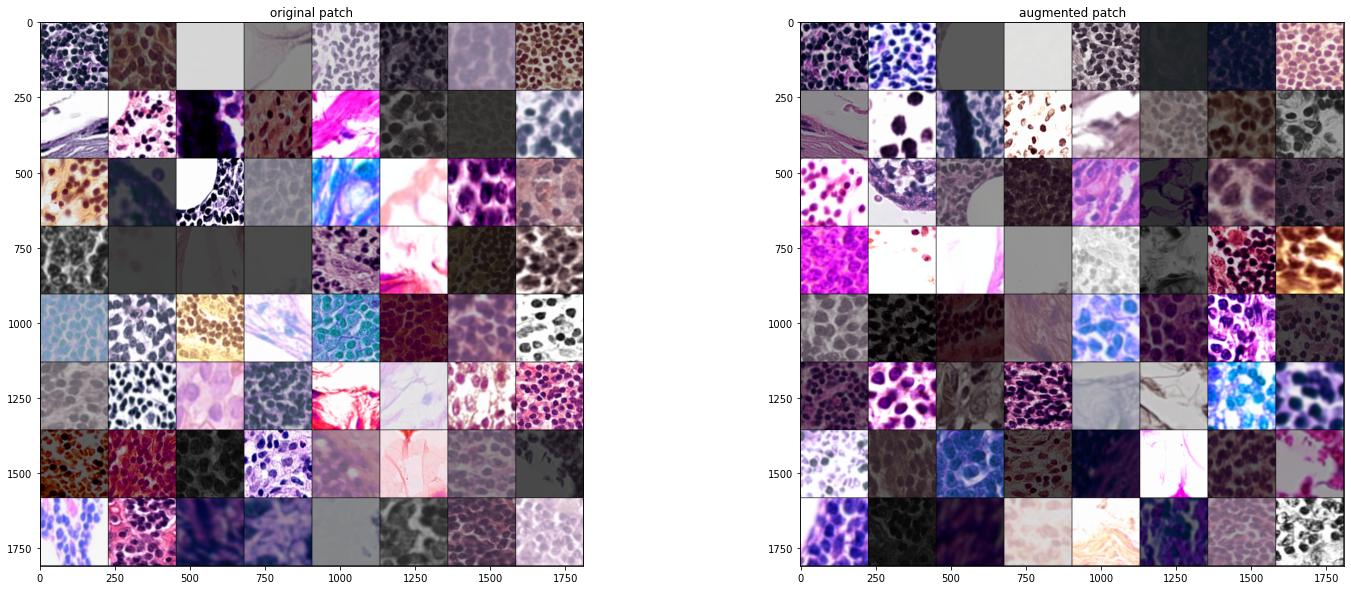

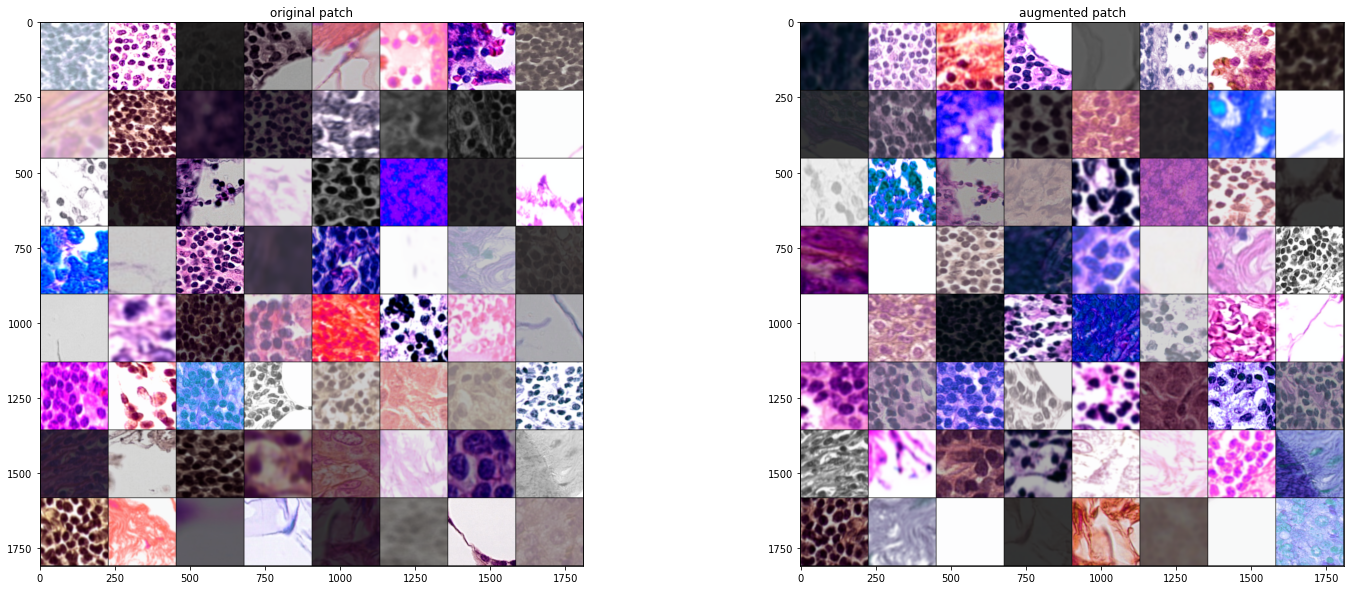

In [14]:
for i, ((img1, img2), label) in enumerate(dataloader):

    img1 = torch.clip(denormalize(img1), 0, 1)
    img2 = torch.clip(denormalize(img2), 0, 1)

    plt.figure(figsize=(25, 10))
    plt.subplot(121)
    plt.title("original patch")
    plt.imshow(make_grid(img1).numpy().transpose(1, 2, 0))


    plt.subplot(122)
    plt.title("augmented patch")
    plt.imshow(make_grid(img2).numpy().transpose(1, 2, 0))
    plt.show()
    
    if i == 5:
        break

In [7]:
# checkpoint_callback = model_checkpoint.ModelCheckpoint(dirpath='models/encoder', save_weights_only=True,  every_n_train_steps=10000, monitor="train_loss")
# datamodule = Camelyon16Preprocessed()
# model = Moco_v2("resnet50",
#                 embd_dim=128,
#                 num_negatives=65536,
#                 use_mlp=True,
#                 batch_size=128,
#                 learning_rate=0.03,
#                 num_workers=4)
# trainer = pl.trainer.Trainer(gpus=1, callbacks=[checkpoint_callback])

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory models/encoder exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model,datamodule=datamodule)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | encoder_q | ResNet | 28.0 M
1 | encoder_k | ResNet | 28.0 M
-------------------------------------
28.0 M    Trainable params
28.0 M    Non-trainable params
55.9 M    Total params
223.733   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool

In [12]:
model.hparams.num_negatives % model.hparams.batch_size

0

In [20]:
model.encoder_q.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [22]:
feature = nn.Sequential(*list(model.encoder_q.children())[:-1]).cpu().eval()

In [25]:
torch.save(feature.state_dict(), "models/encoder/mocov1.pth")